In [1]:
import os
import os.path as osp
import io
import PIL
from PIL import Image
import lmdb
from tqdm import tqdm
print(PIL.__version__)
print(lmdb.__version__)

7.0.0.post3
0.94


# Make LMDB

In [2]:
src = '/media/allen/mass/Downloads/ImageNet/'
branch = 'ILSVRC2012_img_train'
img_src = osp.join(src, branch)
lmdb_path = osp.join(src, 'ilsvrc2012_train')
if not os.path.exists(lmdb_path):
    os.mkdir(lmdb_path)
img_list_path = osp.join(src, "ilsvrc2012_train.txt")

In [3]:
lmdb_env = lmdb.open(lmdb_path, map_size=int(1e12))
lmdb_txn = lmdb_env.begin(write=True)

with open(img_list_path, 'r') as f:
    for line in tqdm(f):
        img_name, label = line.strip().split(" ")
        fname = osp.join(img_src, img_name)        
        f_img = open(fname, 'rb')
        img_str = f_img.read()
        lmdb_txn.put(img_name.encode(), img_str)
lmdb_txn.commit()

1037150it [2:21:19, 116.33it/s]

# Test the lmdb data

In [1]:
dataset = []
with open(img_list_path, 'r') as f:
    for line in f:
        img_name, label = line.strip().split(" ")
        dataset.append((img_name, label))

NameError: name 'img_list_path' is not defined

In [10]:
test_lmdb_env = lmdb.open(lmdb_path)
test_lmdb_txn = test_lmdb_env.begin()
raw = test_lmdb_txn.get(dataset[0][0].encode())
img_byte = io.BytesIO(raw)
test_img = Image.open(img_byte)

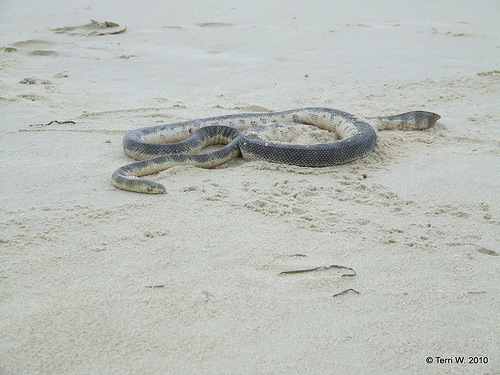

In [11]:
test_img

# Make LMDB for COCO

### making lmdb for train

In [26]:
lmdb_env = lmdb.open(train_lmdb_path, map_size=int(1e12))
lmdb_txn = lmdb_env.begin(write=True)

for (img_path, label) in tqdm(data.train['indice']):
    f_img = open(img_path, 'rb')
    img_str = f_img.read()
    key = img_path.split(cfg.DB.DATA+"/")[-1]
    lmdb_txn.put(key.encode(), img_str)
lmdb_txn.commit()

100%|██████████| 100000/100000 [00:30<00:00, 3254.64it/s]


### making lmdb for val

In [27]:
lmdb_env = lmdb.open(val_lmdb_path, map_size=int(1e12))
lmdb_txn = lmdb_env.begin(write=True)

for (img_path, label) in tqdm(data.val['indice']):
    f_img = open(img_path, 'rb')
    img_str = f_img.read()
    key = img_path.split(cfg.DB.DATA+"/")[-1]
    lmdb_txn.put(key.encode(), img_str)
lmdb_txn.commit()

100%|██████████| 10000/10000 [00:42<00:00, 232.69it/s]


In [34]:
test_lmdb_env = lmdb.open(val_lmdb_path)
test_lmdb_txn = test_lmdb_env.begin()

for (img_path, label) in tqdm(data.val['indice']):
    f_img = open(img_path, 'rb')
    img_str = f_img.read()
    key = img_path.split(cfg.DB.DATA+"/")[-1]
    raw = test_lmdb_txn.get(key.encode())
    img_byte = io.BytesIO(raw)
    test_img = Image.open(img_byte)
    break

  0%|          | 0/10000 [00:00<?, ?it/s]


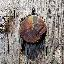

In [35]:
test_img

In [12]:
class A():
    p = 5
    def __init__(self):
        self.j = 1

class B(A):
    p = 6
    def __init__(self):
        super(B, self).__init__()
        print(self.p)

In [16]:
from src.database.data_format.reid import build_reid_dataset
dataset = build_reid_dataset(data.train)

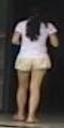

In [22]:
dataset[1000]['inp']